In [1]:
## Loading packages
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
## Getting data
import h5py
hf = h5py.File('regression.h5', 'r')
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))
hf.close()
                         
scaler = MinMaxScaler()
scaler.fit(x_train)

# Scaling data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print("In training set - number of targets: ")
print(y_train.shape)

print("In test set - number of targets: ")
print(y_test.shape)

print("In training set - number of samples and features: ")
print(x_train.shape)

print("In test set - number of samples and features: ")
print(x_test.shape)

#For reproducibility
np.random.seed(222)



In training set - number of targets: 
(500, 1)
In test set - number of targets: 
(10000, 1)
In training set - number of samples and features: 
(500, 2)
In test set - number of samples and features: 
(10000, 2)


In [3]:
## My neural network implementation - as a class

## Includes:

    # Forward pass
    # Backpropagation
    # Custom activation fucntion implementation 
    
    
    # Reference: 
    # General guidlene how to set up neural network class was obtaine from following ebook: https://nnfs.io/,
    # Especially for backpropagation
    # Implementation is my own, no direct coping have been carried out

    
    
class neuralNetwork(object):

    def __init__(self, numberInputs = 2, hiddenLayerDims= [10, 10], numberOutputs=1, activationType = "Custom"):

        self.hiddenLayerDims = hiddenLayerDims
        self.activationType = activationType

        # for plotting

        self.MSEs = []
        self.epochNo = []

        self.MSEsTest = []
        
        self.trainRunsCompleted = 0

        layersCombined = [numberInputs] + hiddenLayerDims + [numberOutputs]

        # initializing weights
        W = []
        for i in range(len(layersCombined) - 1):

            # He et al., weight initialization
            w = np.random.rand(layersCombined[i], layersCombined[i + 1]) * np.sqrt(2./layersCombined[i])
            W.append(w)
        self.W = W

        # initialize biases
        # I only use biases on hidden layers
        biases = []
        for i in range(len(layersCombined) - 2):
            b = np.zeros(layersCombined[i + 1])
            biases.append(b)
        self.biases = biases

        # initialize bias derivatives/gradients
        # I only use biases on hidden layers
        biasDerivatives = []
        for i in range(len(layersCombined) - 2):
            a = np.zeros(layersCombined[i + 1])
            biasDerivatives.append(a)
        self.biasDerivatives = biasDerivatives

        # initialize activation derivatives/gradients
        derivatives = []
        for i in range(len(layersCombined) - 1):
            d = np.zeros((layersCombined[i], layersCombined[i + 1]))
            derivatives.append(d)
        self.derivatives = derivatives

        # initialize activations
        activations = []
        for i in range(len(layersCombined)):
            a = np.zeros(layersCombined[i])
            activations.append(a)
        self.activations = activations


    def forwardPass (self, xInput):

        activations = xInput

        self.activations[0] = activations

        # forward propagate
        for i, w in enumerate(self.W):

            prevLayer = np.dot(activations, w)

            # if in hidden layer add biases before running activation function
            if(i + 1 <= len(self.hiddenLayerDims)):
                activations = self._activationFunction(prevLayer + self.biases[i])
            else:
                activations = self._activationFunction(prevLayer)

            # save  activations from current layer
            self.activations[i + 1] = activations

        # output layer result for loss calculation
        return activations


    def backPropagate(self, error):
        
        error = error

        for i in reversed(range(len(self.derivatives))):
            
            activationsNextLayer = self.activations[i+1]

            # Calculating delta
            delta = error * self._activationDerivate(activationsNextLayer)

            # Delta reshaped
            deltaReshaped = delta.reshape(delta.shape[0], -1).T

            # From saved store
            currentActivations = self.activations[i]

            # current activations reshaped
            currentActivationsReshaped = currentActivations.reshape(currentActivations.shape[0],-1)

            # Getting and saving derivatives/gradients
            self.derivatives[i] = np.dot(currentActivationsReshaped, deltaReshaped)

            # If in hidden layer, update calculate bias gradients
            if i != 0:
                self.biasDerivatives[i-1] = np.sum(self.derivatives[i], axis=1, keepdims=True).reshape((-1))

            # backpropogate error to previous layer andrepeate
            error = np.dot(delta, self.W[i].T)


    def updateGradients(self, LR):

        # update biases and weights
        for i in range(len(self.W)):
            self.W[i] += self.derivatives[i] * LR

            # if in hidden layer, also update biases
            if i != 0:
                self.biases[i-1] += self.biasDerivatives[i-1] * LR


    def train(self, x_train, y_train, x_test, y_test, epochs, LR):
        
        x_train, y_train = shuffle(x_train, y_train)

        for i in range(epochs):
            # Tried to implement adaptive LR but it did not work
            #LR = LR * (1 / 1 + i // 50 )
            errorsSummedTrain = 0
            errorsSummedTest = 0
            
            # Train
            for k, dat_x in enumerate(x_train):
                y_real = y_train[k]

                # Forward propagate
                y_hat = self.forwardPass(dat_x)

                # Compute error for current batch sized n = 1
                error = y_real - y_hat

                # Backpropagation
                self.backPropagate(error)

                # Updating biases and weights
                self.updateGradients(LR)
                

            # Test eval
            if x_test is not None and y_test is not None:
                for k, dat_x in enumerate(x_test):
                    y_real = y_test[k]

                    # Forward propagate
                    y_hat = self.forwardPass(dat_x)

                    # Summing error for reporting
                    errorsSummedTest += self._mse(y_real, y_hat)
                    
            # Train eval
            for k, dat_x in enumerate(x_train):
                y_real = y_train[k]

                # Forward propagate
                y_hat = self.forwardPass(dat_x)

                # Summing error for reporting
                errorsSummedTrain += self._mse(y_real, y_hat)

            if x_test is not None and y_test is not None:
                print("Test error for epoch {} is {}".format(i+1, (errorsSummedTest / len(y_test)) ))
            print("Train error for epoch {} is {}".format(i+1, ( errorsSummedTrain / len(y_train) ) ))
            print(" /// --- /// ")
            

            self.epochNo.append(i + 1)
            self.MSEs.append(errorsSummedTrain / len(y_train))
            if x_test is not None and y_test is not None:
                self.MSEsTest.append(errorsSummedTest / len(y_test))


    def _activationDerivate(self, x):
        if self.activationType == "Custom":
            return 2.0 * x
        elif self.activationType == "ReLU":
            return (x > 0).astype(int)


    def _activationFunction(self, x):
        if self.activationType == "Custom":
            return np.square(x)
        elif self.activationType == "ReLU":
            return np.maximum(0.,x)


    def _mse(self, y_real, y_hat):
        return np.average((y_real - y_hat) ** 2)

In [4]:
## Relu training 

neuralNetworkInstanceReLU = neuralNetwork(2, [10,10], 1, "ReLU")
neuralNetworkInstanceReLU.train(x_train, y_train, x_test, y_test, 400, 0.00006)

#0.00005


Test error for epoch 1 is 955.7110564411454
Train error for epoch 1 is 939.3923778744539
 /// --- /// 
Test error for epoch 2 is 831.3390174320847
Train error for epoch 2 is 816.0001133730963
 /// --- /// 
Test error for epoch 3 is 750.7355709585788
Train error for epoch 3 is 736.420939426898
 /// --- /// 
Test error for epoch 4 is 694.1497472689385
Train error for epoch 4 is 680.7983743495747
 /// --- /// 
Test error for epoch 5 is 651.9136201801329
Train error for epoch 5 is 639.4362795445476
 /// --- /// 
Test error for epoch 6 is 618.7456509683755
Train error for epoch 6 is 607.0507630783788
 /// --- /// 
Test error for epoch 7 is 591.5965493701473
Train error for epoch 7 is 580.5993404716119
 /// --- /// 
Test error for epoch 8 is 568.6319689246652
Train error for epoch 8 is 558.2567941497321
 /// --- /// 
Test error for epoch 9 is 548.7074904360971
Train error for epoch 9 is 538.8876450634624
 /// --- /// 
Test error for epoch 10 is 531.0839673498832
Train error for epoch 10 is 5

Test error for epoch 79 is 256.37750849003316
Train error for epoch 79 is 254.1411705543695
 /// --- /// 
Test error for epoch 80 is 255.4294975093665
Train error for epoch 80 is 253.22434535697803
 /// --- /// 
Test error for epoch 81 is 254.5002295470269
Train error for epoch 81 is 252.32435399635924
 /// --- /// 
Test error for epoch 82 is 253.59012638222384
Train error for epoch 82 is 251.4442552761753
 /// --- /// 
Test error for epoch 83 is 252.69752368118935
Train error for epoch 83 is 250.58006989831583
 /// --- /// 
Test error for epoch 84 is 251.82196208086657
Train error for epoch 84 is 249.73157536554717
 /// --- /// 
Test error for epoch 85 is 250.96318207134348
Train error for epoch 85 is 248.90027229220493
 /// --- /// 
Test error for epoch 86 is 250.12015722533403
Train error for epoch 86 is 248.08459082752253
 /// --- /// 
Test error for epoch 87 is 249.293438724855
Train error for epoch 87 is 247.28373777348486
 /// --- /// 
Test error for epoch 88 is 248.481729216367

Test error for epoch 155 is 214.06999853148133
Train error for epoch 155 is 213.3843204235589
 /// --- /// 
Test error for epoch 156 is 213.73533659548966
Train error for epoch 156 is 213.06021061757863
 /// --- /// 
Test error for epoch 157 is 213.40412244816235
Train error for epoch 157 is 212.73962260273328
 /// --- /// 
Test error for epoch 158 is 213.0765271527791
Train error for epoch 158 is 212.42257933758208
 /// --- /// 
Test error for epoch 159 is 212.75138541777488
Train error for epoch 159 is 212.1070004788891
 /// --- /// 
Test error for epoch 160 is 212.42976654343116
Train error for epoch 160 is 211.7949192146418
 /// --- /// 
Test error for epoch 161 is 212.11160520116024
Train error for epoch 161 is 211.4861871142494
 /// --- /// 
Test error for epoch 162 is 211.79662458443977
Train error for epoch 162 is 211.18048264340874
 /// --- /// 
Test error for epoch 163 is 211.4850224759308
Train error for epoch 163 is 210.87801509904318
 /// --- /// 
Test error for epoch 164 

Test error for epoch 231 is 195.90116428557457
Train error for epoch 231 is 195.7341199997913
 /// --- /// 
Test error for epoch 232 is 195.73327207434946
Train error for epoch 232 is 195.5711520309685
 /// --- /// 
Test error for epoch 233 is 195.56684308432258
Train error for epoch 233 is 195.40963680775513
 /// --- /// 
Test error for epoch 234 is 195.40185827231295
Train error for epoch 234 is 195.2495556382039
 /// --- /// 
Test error for epoch 235 is 195.23796068796344
Train error for epoch 235 is 195.09043662574436
 /// --- /// 
Test error for epoch 236 is 195.07546501350353
Train error for epoch 236 is 194.932790332241
 /// --- /// 
Test error for epoch 237 is 194.91391222785003
Train error for epoch 237 is 194.77575889520233
 /// --- /// 
Test error for epoch 238 is 194.7536146519925
Train error for epoch 238 is 194.6200096375445
 /// --- /// 
Test error for epoch 239 is 194.5944163945062
Train error for epoch 239 is 194.46519225826825
 /// --- /// 
Test error for epoch 240 is

Test error for epoch 307 is 186.21908343468453
Train error for epoch 307 is 186.31366224940416
 /// --- /// 
Test error for epoch 308 is 186.124170814363
Train error for epoch 308 is 186.22130515749149
 /// --- /// 
Test error for epoch 309 is 186.02993378624637
Train error for epoch 309 is 186.1296110478016
 /// --- /// 
Test error for epoch 310 is 185.9363166408087
Train error for epoch 310 is 186.03850208898956
 /// --- /// 
Test error for epoch 311 is 185.8433675474011
Train error for epoch 311 is 185.9480666958736
 /// --- /// 
Test error for epoch 312 is 185.75108747780143
Train error for epoch 312 is 185.8582938239366
 /// --- /// 
Test error for epoch 313 is 185.65947228337282
Train error for epoch 313 is 185.76917533980816
 /// --- /// 
Test error for epoch 314 is 185.56795870224684
Train error for epoch 314 is 185.67994152435207
 /// --- /// 
Test error for epoch 315 is 185.47703209935034
Train error for epoch 315 is 185.59135001255999
 /// --- /// 
Test error for epoch 316 i

Test error for epoch 383 is 180.4446279914558
Train error for epoch 383 is 180.69605949175474
 /// --- /// 
Test error for epoch 384 is 180.3856751400768
Train error for epoch 384 is 180.63883735475875
 /// --- /// 
Test error for epoch 385 is 180.32709726557894
Train error for epoch 385 is 180.58198413462847
 /// --- /// 
Test error for epoch 386 is 180.26889339339525
Train error for epoch 386 is 180.525498294298
 /// --- /// 
Test error for epoch 387 is 180.2108667962961
Train error for epoch 387 is 180.46912402960155
 /// --- /// 
Test error for epoch 388 is 180.152649236937
Train error for epoch 388 is 180.41240885331544
 /// --- /// 
Test error for epoch 389 is 180.0947358503376
Train error for epoch 389 is 180.3560154249496
 /// --- /// 
Test error for epoch 390 is 180.03713921491152
Train error for epoch 390 is 180.29994354355057
 /// --- /// 
Test error for epoch 391 is 179.97987052321682
Train error for epoch 391 is 180.24419852007784
 /// --- /// 
Test error for epoch 392 is 

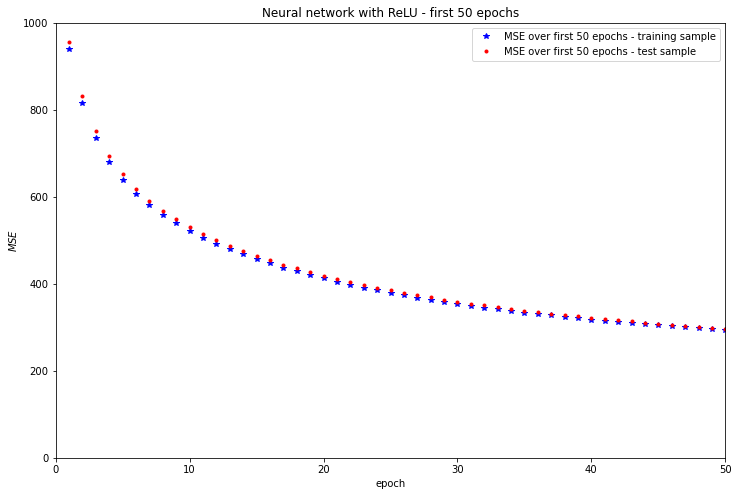

In [11]:
# Neural network with ReLU activation function estimation - first 50 epochs

plt.figure(figsize=(12,8))
plt.plot(neuralNetworkInstanceReLU.epochNo[0:50], neuralNetworkInstanceReLU.MSEs[0:50], '*', c = 'b', label = 'MSE over first 50 epochs - training sample')
plt.plot(neuralNetworkInstanceReLU.epochNo[0:50], neuralNetworkInstanceReLU.MSEsTest[0:50], '.', c = 'r', label = 'MSE over first 50 epochs - test sample')


plt.xlabel('epoch')
plt.ylabel('$MSE$')
plt.xlim((0, 50))
plt.ylim((0,1000))
plt.title('Neural network with ReLU - first 50 epochs')
plt.legend()

In [6]:
## Testing

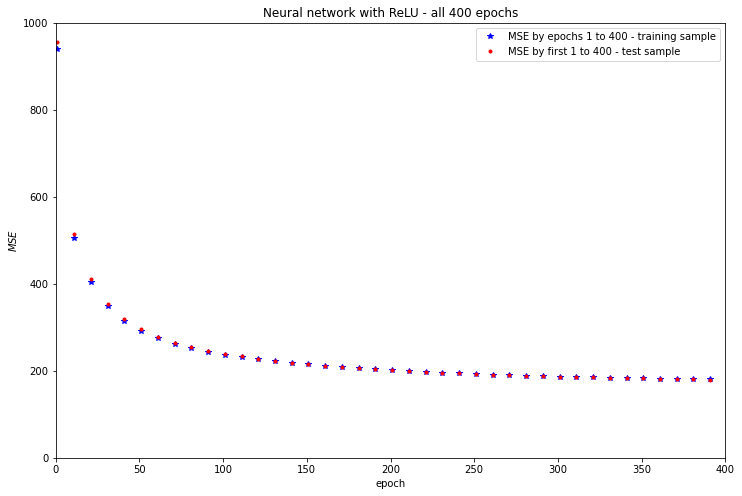

In [12]:
# Neural network with ReLU activation function estimation - 400 epochs

plt.figure(figsize=(12,8))
plt.plot(neuralNetworkInstanceReLU.epochNo[::10], neuralNetworkInstanceReLU.MSEs[::10], '*', c = 'b', label = 'MSE by epochs 1 to 400 - training sample')
plt.plot(neuralNetworkInstanceReLU.epochNo[::10], neuralNetworkInstanceReLU.MSEsTest[::10], '.', c = 'r', label = 'MSE by first 1 to 400 - test sample')


plt.xlabel('epoch')
plt.ylabel('$MSE$')
plt.xlim((0, 400))
plt.ylim((0,1000))
plt.title('Neural network with ReLU - all 400 epochs')
plt.legend()

In [8]:
#Custom activation function training 

neuralNetworkInstanceCustom = neuralNetwork(2, [10,10], 1, "Custom")
neuralNetworkInstanceCustom.train(x_train, y_train, x_test, y_test, 400, 0.00000003)


Test error for epoch 1 is 3419.4128520204754
Train error for epoch 1 is 3464.124938335397
 /// --- /// 
Test error for epoch 2 is 3419.0027986782598
Train error for epoch 2 is 3463.613982223032
 /// --- /// 
Test error for epoch 3 is 3418.574548151621
Train error for epoch 3 is 3463.080449288856
 /// --- /// 
Test error for epoch 4 is 3418.1267881942213
Train error for epoch 4 is 3462.522715964142
 /// --- /// 
Test error for epoch 5 is 3417.6580734176064
Train error for epoch 5 is 3461.938994290166
 /// --- /// 
Test error for epoch 6 is 3417.1668076512547
Train error for epoch 6 is 3461.3273101747814
 /// --- /// 
Test error for epoch 7 is 3416.6512233869425
Train error for epoch 7 is 3460.685478059426
 /// --- /// 
Test error for epoch 8 is 3416.1093577228576
Train error for epoch 8 is 3460.011071279231
 /// --- /// 
Test error for epoch 9 is 3415.539024086571
Train error for epoch 9 is 3459.3013872289694
 /// --- /// 
Test error for epoch 10 is 3414.9377788376905
Train error for ep

Test error for epoch 79 is 46.120030019809
Train error for epoch 79 is 45.18847975782646
 /// --- /// 
Test error for epoch 80 is 45.82428900756059
Train error for epoch 80 is 44.88157137737808
 /// --- /// 
Test error for epoch 81 is 45.5956577195113
Train error for epoch 81 is 44.64294436401305
 /// --- /// 
Test error for epoch 82 is 45.413760068873614
Train error for epoch 82 is 44.4523466980346
 /// --- /// 
Test error for epoch 83 is 45.264523119847624
Train error for epoch 83 is 44.295690378201265
 /// --- /// 
Test error for epoch 84 is 45.138263090628236
Train error for epoch 84 is 44.16320006617138
 /// --- /// 
Test error for epoch 85 is 45.02832311522397
Train error for epoch 85 is 44.04809120837728
 /// --- /// 
Test error for epoch 86 is 44.93012045914128
Train error for epoch 86 is 43.94564208411775
 /// --- /// 
Test error for epoch 87 is 44.84048859371316
Train error for epoch 87 is 43.85255028123574
 /// --- /// 
Test error for epoch 88 is 44.75722696391823
Train erro

Test error for epoch 156 is 41.47229066004812
Train error for epoch 156 is 40.48201342303437
 /// --- /// 
Test error for epoch 157 is 41.43734765826866
Train error for epoch 157 is 40.44728362428965
 /// --- /// 
Test error for epoch 158 is 41.40263261499322
Train error for epoch 158 is 40.412782016176806
 /// --- /// 
Test error for epoch 159 is 41.36814185357095
Train error for epoch 159 is 40.37850490550031
 /// --- /// 
Test error for epoch 160 is 41.33387177629043
Train error for epoch 160 is 40.34444867823912
 /// --- /// 
Test error for epoch 161 is 41.299818862264345
Train error for epoch 161 is 40.31060979742583
 /// --- /// 
Test error for epoch 162 is 41.26597966538188
Train error for epoch 162 is 40.27698480109557
 /// --- /// 
Test error for epoch 163 is 41.2323508123281
Train error for epoch 163 is 40.24357030030002
 /// --- /// 
Test error for epoch 164 is 41.198929000667384
Train error for epoch 164 is 40.21036297718723
 /// --- /// 
Test error for epoch 165 is 41.1657

Test error for epoch 233 is 39.256492160022994
Train error for epoch 233 is 38.28235062355576
 /// --- /// 
Test error for epoch 234 is 39.23218316429315
Train error for epoch 234 is 38.258237058866605
 /// --- /// 
Test error for epoch 235 is 39.2079544539673
Train error for epoch 235 is 38.23420320253605
 /// --- /// 
Test error for epoch 236 is 39.18380512978925
Train error for epoch 236 is 38.21024814890839
 /// --- /// 
Test error for epoch 237 is 39.159734306546035
Train error for epoch 237 is 38.1863710064384
 /// --- /// 
Test error for epoch 238 is 39.13574111280812
Train error for epoch 238 is 38.16257089743341
 /// --- /// 
Test error for epoch 239 is 39.11182469067744
Train error for epoch 239 is 38.1388469577981
 /// --- /// 
Test error for epoch 240 is 39.087984195539676
Train error for epoch 240 is 38.115198336788474
 /// --- /// 
Test error for epoch 241 is 39.06421879582596
Train error for epoch 241 is 38.09162419677025
 /// --- /// 
Test error for epoch 242 is 39.0405

Test error for epoch 310 is 37.56882204270771
Train error for epoch 310 is 36.607651520759624
 /// --- /// 
Test error for epoch 311 is 37.548828597635996
Train error for epoch 311 is 36.587794489774495
 /// --- /// 
Test error for epoch 312 is 37.52887404145646
Train error for epoch 312 is 36.567975434458205
 /// --- /// 
Test error for epoch 313 is 37.50895808259244
Train error for epoch 313 is 36.54819406054937
 /// --- /// 
Test error for epoch 314 is 37.489080433538795
Train error for epoch 314 is 36.52845007789585
 /// --- /// 
Test error for epoch 315 is 37.46924081080697
Train error for epoch 315 is 36.50874320039746
 /// --- /// 
Test error for epoch 316 is 37.44943893486571
Train error for epoch 316 is 36.48907314594831
 /// --- /// 
Test error for epoch 317 is 37.429674530090026
Train error for epoch 317 is 36.469439636383974
 /// --- /// 
Test error for epoch 318 is 37.40994732470427
Train error for epoch 318 is 36.44984239742548
 /// --- /// 
Test error for epoch 319 is 37

Test error for epoch 387 is 36.12636108770036
Train error for epoch 387 is 35.17287293013435
 /// --- /// 
Test error for epoch 388 is 36.10874494238916
Train error for epoch 388 is 35.155317535615076
 /// --- /// 
Test error for epoch 389 is 36.09115397793922
Train error for epoch 389 is 35.137786300723164
 /// --- /// 
Test error for epoch 390 is 36.07358809995762
Train error for epoch 390 is 35.1202791308986
 /// --- /// 
Test error for epoch 391 is 36.05604721554336
Train error for epoch 391 is 35.10279593310252
 /// --- /// 
Test error for epoch 392 is 36.03853123326749
Train error for epoch 392 is 35.085336615798724
 /// --- /// 
Test error for epoch 393 is 36.02104006315711
Train error for epoch 393 is 35.06790108893707
 /// --- /// 
Test error for epoch 394 is 36.003573616675375
Train error for epoch 394 is 35.05048926393225
 /// --- /// 
Test error for epoch 395 is 35.98613180670401
Train error for epoch 395 is 35.03310105364767
 /// --- /// 
Test error for epoch 396 is 35.968

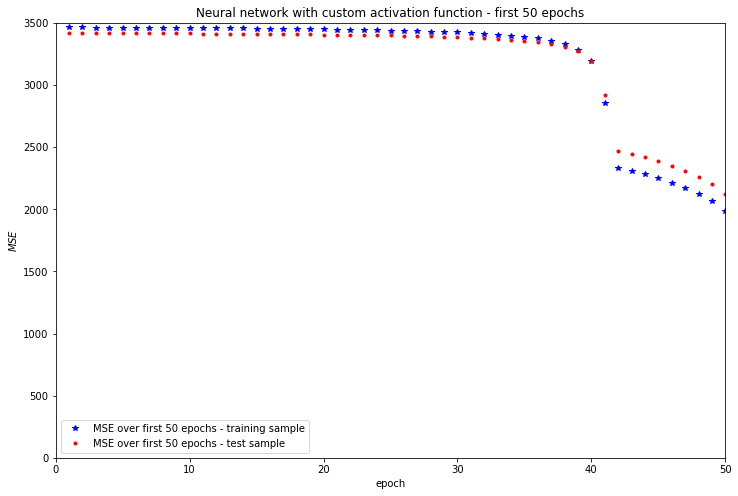

In [13]:
# Neural network with ReLU activation function estimation - first 50 epochs

plt.figure(figsize=(12,8))
plt.plot(neuralNetworkInstanceCustom.epochNo[0:50], neuralNetworkInstanceCustom.MSEs[0:50], '*', c = 'b', label = 'MSE over first 50 epochs - training sample')
plt.plot(neuralNetworkInstanceCustom.epochNo[0:50], neuralNetworkInstanceCustom.MSEsTest[0:50], '.', c = 'r', label = 'MSE over first 50 epochs - test sample')


plt.xlabel('epoch')
plt.ylabel('$MSE$')
plt.xlim((0, 50))
plt.ylim((0,3500))
plt.title('Neural network with custom activation function - first 50 epochs')
plt.legend()

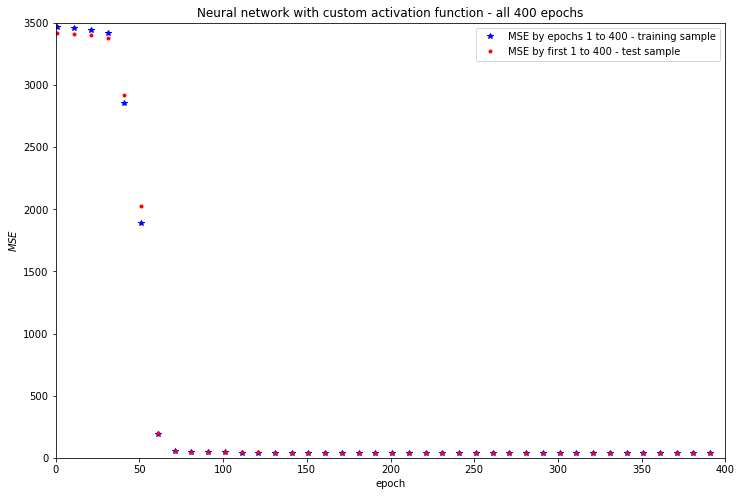

In [14]:
# Neural network with ReLU activation function estimation - 400 epochs

plt.figure(figsize=(12,8))
plt.plot(neuralNetworkInstanceCustom.epochNo[::10], neuralNetworkInstanceCustom.MSEs[::10], '*', c = 'b', label = 'MSE by epochs 1 to 400 - training sample')
plt.plot(neuralNetworkInstanceCustom.epochNo[::10], neuralNetworkInstanceCustom.MSEsTest[::10], '.', c = 'r', label = 'MSE by first 1 to 400 - test sample')


plt.xlabel('epoch')
plt.ylabel('$MSE$')
plt.xlim((0, 400))
plt.ylim((0,3500))
plt.title('Neural network with custom activation function - all 400 epochs')
plt.legend()

In [28]:
## Adam optimizer

"""Stochastic optimization methods for MLP
"""

# Authors: Jiyuan Qian <jq401@nyu.edu>
# License: BSD 3 clause

import numpy as np


class BaseOptimizer:
    """Base (Stochastic) gradient descent optimizer

    Parameters
    ----------
    params : list, length = len(coefs_) + len(intercepts_)
        The concatenated list containing coefs_ and intercepts_ in MLP model.
        Used for initializing velocities and updating params

    learning_rate_init : float, default=0.1
        The initial learning rate used. It controls the step-size in updating
        the weights

    Attributes
    ----------
    learning_rate : float
        the current learning rate
    """

    def __init__(self, params, learning_rate_init=0.1):
        self.params = [param for param in params]
        self.learning_rate_init = learning_rate_init
        self.learning_rate = float(learning_rate_init)

    def update_params(self, grads):
        """Update parameters with given gradients

        Parameters
        ----------
        grads : list, length = len(params)
            Containing gradients with respect to coefs_ and intercepts_ in MLP
            model. So length should be aligned with params
        """
        updates = self._get_updates(grads)
        for param, update in zip(self.params, updates):
            param += update

    def iteration_ends(self, time_step):
        """Perform update to learning rate and potentially other states at the
        end of an iteration
        """
        pass

    def trigger_stopping(self, msg, verbose):
        """Decides whether it is time to stop training

        Parameters
        ----------
        msg : str
            Message passed in for verbose output

        verbose : bool
            Print message to stdin if True

        Returns
        -------
        is_stopping : bool
            True if training needs to stop
        """
        if verbose:
            print(msg + " Stopping.")
        return True


class SGDOptimizer(BaseOptimizer):
    """Stochastic gradient descent optimizer with momentum

    Parameters
    ----------
    params : list, length = len(coefs_) + len(intercepts_)
        The concatenated list containing coefs_ and intercepts_ in MLP model.
        Used for initializing velocities and updating params

    learning_rate_init : float, default=0.1
        The initial learning rate used. It controls the step-size in updating
        the weights

    lr_schedule : {'constant', 'adaptive', 'invscaling'}, default='constant'
        Learning rate schedule for weight updates.

        -'constant', is a constant learning rate given by
         'learning_rate_init'.

        -'invscaling' gradually decreases the learning rate 'learning_rate_' at
          each time step 't' using an inverse scaling exponent of 'power_t'.
          learning_rate_ = learning_rate_init / pow(t, power_t)

        -'adaptive', keeps the learning rate constant to
         'learning_rate_init' as long as the training keeps decreasing.
         Each time 2 consecutive epochs fail to decrease the training loss by
         tol, or fail to increase validation score by tol if 'early_stopping'
         is on, the current learning rate is divided by 5.

    momentum : float, default=0.9
        Value of momentum used, must be larger than or equal to 0

    nesterov : bool, default=True
        Whether to use nesterov's momentum or not. Use nesterov's if True

    power_t : float, default=0.5
        Power of time step 't' in inverse scaling. See `lr_schedule` for
        more details.

    Attributes
    ----------
    learning_rate : float
        the current learning rate

    velocities : list, length = len(params)
        velocities that are used to update params
    """

    def __init__(self, params, learning_rate_init=0.1, lr_schedule='constant',
                 momentum=0.9, nesterov=True, power_t=0.5):
        super().__init__(params, learning_rate_init)

        self.lr_schedule = lr_schedule
        self.momentum = momentum
        self.nesterov = nesterov
        self.power_t = power_t
        self.velocities = [np.zeros_like(param) for param in params]

    def iteration_ends(self, time_step):
        """Perform updates to learning rate and potential other states at the
        end of an iteration

        Parameters
        ----------
        time_step : int
            number of training samples trained on so far, used to update
            learning rate for 'invscaling'
        """
        if self.lr_schedule == 'invscaling':
            self.learning_rate = (float(self.learning_rate_init) /
                                  (time_step + 1) ** self.power_t)

    def trigger_stopping(self, msg, verbose):
        if self.lr_schedule != 'adaptive':
            if verbose:
                print(msg + " Stopping.")
            return True

        if self.learning_rate <= 1e-6:
            if verbose:
                print(msg + " Learning rate too small. Stopping.")
            return True

        self.learning_rate /= 5.
        if verbose:
            print(msg + " Setting learning rate to %f" %
                  self.learning_rate)
        return False

    def _get_updates(self, grads):
        """Get the values used to update params with given gradients

        Parameters
        ----------
        grads : list, length = len(coefs_) + len(intercepts_)
            Containing gradients with respect to coefs_ and intercepts_ in MLP
            model. So length should be aligned with params

        Returns
        -------
        updates : list, length = len(grads)
            The values to add to params
        """
        updates = [self.momentum * velocity - self.learning_rate * grad
                   for velocity, grad in zip(self.velocities, grads)]
        self.velocities = updates

        if self.nesterov:
            updates = [self.momentum * velocity - self.learning_rate * grad
                       for velocity, grad in zip(self.velocities, grads)]

        return updates


class AdamOptimizer(BaseOptimizer):
    """Stochastic gradient descent optimizer with Adam

    Note: All default values are from the original Adam paper

    Parameters
    ----------
    params : list, length = len(coefs_) + len(intercepts_)
        The concatenated list containing coefs_ and intercepts_ in MLP model.
        Used for initializing velocities and updating params

    learning_rate_init : float, default=0.001
        The initial learning rate used. It controls the step-size in updating
        the weights

    beta_1 : float, default=0.9
        Exponential decay rate for estimates of first moment vector, should be
        in [0, 1)

    beta_2 : float, default=0.999
        Exponential decay rate for estimates of second moment vector, should be
        in [0, 1)

    epsilon : float, default=1e-8
        Value for numerical stability

    Attributes
    ----------
    learning_rate : float
        The current learning rate

    t : int
        Timestep

    ms : list, length = len(params)
        First moment vectors

    vs : list, length = len(params)
        Second moment vectors

    References
    ----------
    Kingma, Diederik, and Jimmy Ba.
    "Adam: A method for stochastic optimization."
    arXiv preprint arXiv:1412.6980 (2014).
    """

    def __init__(self, params, learning_rate_init=0.001, beta_1=0.9,
                 beta_2=0.999, epsilon=1e-8):
        super().__init__(params, learning_rate_init)

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 0
        self.ms = [np.zeros_like(param) for param in params]
        self.vs = [np.zeros_like(param) for param in params]

    def _get_updates(self, grads):
        """Get the values used to update params with given gradients

        Parameters
        ----------
        grads : list, length = len(coefs_) + len(intercepts_)
            Containing gradients with respect to coefs_ and intercepts_ in MLP
            model. So length should be aligned with params

        Returns
        -------
        updates : list, length = len(grads)
            The values to add to params
        """
        self.t += 1
        self.ms = [self.beta_1 * m + (1 - self.beta_1) * grad
                   for m, grad in zip(self.ms, grads)]
        self.vs = [self.beta_2 * v + (1 - self.beta_2) * (grad ** 2)
                   for v, grad in zip(self.vs, grads)]
        self.learning_rate = (self.learning_rate_init *
                              np.sqrt(1 - self.beta_2 ** self.t) /
                              (1 - self.beta_1 ** self.t))
        updates = [-self.learning_rate * m / (np.sqrt(v) + self.epsilon)
                   for m, v in zip(self.ms, self.vs)]
        return updates


In [32]:
# Adam optimizer implementation
import copy 

epsilon = 0.2
LRA = 0.0001
neuralNetworkInstanceAdam = neuralNetwork(2, [10,10], 1, "ReLU")

weightsGradients = copy.deepcopy(neuralNetworkInstanceAdam.W)
biasesGradients = copy.deepcopy(neuralNetworkInstanceAdam.biases)

optimizer = AdamOptimizer(copy.deepcopy(neuralNetworkInstanceAdam.W) + 
                                  copy.deepcopy(neuralNetworkInstanceAdam.biases),  LRA, 0.9, 0.999,1e-08)

trainErrors = []
testErrors = []
epochs = []

for ep in range(200):
    for k, dat_x in enumerate(x_train):

        xIn = dat_x
        yIn = y_train[k]


        for i, val_l1 in enumerate(neuralNetworkInstanceAdam.W):
            for ii, val_l2 in enumerate(val_l1):
                for iii, val_l3 in enumerate(val_l2):
                    #print(i, ii, iii, val_l3)

                    # Plus side
                    temp_instance_plus = neuralNetwork(2, [10,10], 1, "ReLU")

                    # Make forward pass with right parameters against W and biases
                    temp_instance_plus.W = copy.deepcopy(neuralNetworkInstanceAdam.W)
                    temp_instance_plus.biases = copy.deepcopy(neuralNetworkInstanceAdam.biases)

                    temp_instance_plus.W[i][ii][iii] = temp_instance_plus.W[i][ii][iii] + epsilon
                    plus_loss = temp_instance_plus._mse(yIn, temp_instance_plus.forwardPass(xIn))


                    # Minus side
                    temp_instance_minus = neuralNetwork(2, [10,10], 1, "ReLU")

                    # Make forward pass with right parameters against W and biases
                    temp_instance_minus.W = copy.deepcopy(neuralNetworkInstanceAdam.W)
                    temp_instance_minus.biases = copy.deepcopy(neuralNetworkInstanceAdam.biases)

                    temp_instance_minus.W[i][ii][iii] = temp_instance_minus.W[i][ii][iii] - epsilon
                    minus_loss = temp_instance_minus._mse(yIn, temp_instance_minus.forwardPass(xIn))

                    # Calculating gradient
                    weightsGradients[i][ii][iii] = (plus_loss - minus_loss) / (epsilon * 2)


        for i, val_l1 in enumerate(neuralNetworkInstanceAdam.biases):
            for ii, val_l2 in enumerate(val_l1):
                    #print(i, ii, val_l2)

                    # Plus side
                    temp_instance_plus = neuralNetwork(2, [10,10], 1, "ReLU")

                    # Make forward pass with right parameters against W and biases
                    temp_instance_plus.W = copy.deepcopy(neuralNetworkInstanceAdam.W)
                    temp_instance_plus.biases = copy.deepcopy(neuralNetworkInstanceAdam.biases)

                    temp_instance_plus.biases[i][ii] = temp_instance_plus.biases[i][ii] + epsilon
                    plus_loss = temp_instance_plus._mse(yIn, temp_instance_plus.forwardPass(xIn))


                    # Minus side
                    temp_instance_minus = neuralNetwork(2, [10,10], 1, "ReLU")

                    # Make forward pass with right parameters against W and biases
                    temp_instance_minus.W = copy.deepcopy(neuralNetworkInstanceAdam.W)
                    temp_instance_minus.biases = copy.deepcopy(neuralNetworkInstanceAdam.biases)

                    temp_instance_minus.biases[i][ii] = temp_instance_minus.biases[i][ii] - epsilon
                    minus_loss = temp_instance_minus._mse(yIn, temp_instance_minus.forwardPass(xIn))

                    # Calculating gradient
                    biasesGradients[i][ii] = (plus_loss - minus_loss) / (epsilon * 2)


        updatesFromAdam = optimizer._get_updates(weightsGradients + biasesGradients)
        #print(updatesFromAdam)
                
        ## Updating weights 
        for i, val_l1 in enumerate(neuralNetworkInstanceAdam.W):
            for ii, val_l2 in enumerate(val_l1):
                for iii, val_l3 in enumerate(val_l2):
                    
                    neuralNetworkInstanceAdam.W[i][ii][iii] += updatesFromAdam[0:3][i][ii][iii]
        
        ## Updating biases
        for i, val_l1 in enumerate(neuralNetworkInstanceAdam.biases):
            for ii, val_l2 in enumerate(val_l1):
                neuralNetworkInstanceAdam.biases[i][ii] += updatesFromAdam[3:5][i][ii]
        

        optimizer = AdamOptimizer(copy.deepcopy(neuralNetworkInstanceAdam.W) + 
                                  copy.deepcopy(neuralNetworkInstanceAdam.biases),  LRA, 0.9, 0.999,1e-08)
    
    # Train eval
    errorsSummedTrain = 0
    for k, dat_x in enumerate(x_train):
        y_real = y_train[k]

        # Forward propagate
        y_hat = neuralNetworkInstanceAdam.forwardPass(dat_x)

        # Summing error for reporting
        errorsSummedTrain += neuralNetworkInstanceAdam._mse(y_real, y_hat)
    
    # Test eval
    errorsSummedTest = 0
    for k, dat_x in enumerate(x_test):
        y_real = y_test[k]

        # Forward propagate
        y_hat = neuralNetworkInstanceAdam.forwardPass(dat_x)

        # Summing error for reporting
        errorsSummedTest += neuralNetworkInstanceAdam._mse(y_real, y_hat)
        
    epochs.append(ep + 1)
    trainErrors.append( ( errorsSummedTrain / len(y_train)))
    testErrors.append(( errorsSummedTest / len(y_test) ))
        
    print("Train error for epoch {} is {}".format(ep+1, ( errorsSummedTrain / len(y_train) ) ))
    print("Test error for epoch {} is {}".format(ep+1, ( errorsSummedTest / len(y_test) ) ))
    print(" /// --- /// ")
    

Train error for epoch 1 is 3205.3428441816477
Test error for epoch 1 is 3165.771284527334
 /// --- /// 
Train error for epoch 2 is 2997.0440857846197
Test error for epoch 2 is 2964.1679749082614
 /// --- /// 
Train error for epoch 3 is 2748.0120880289583
Test error for epoch 3 is 2722.831472918576
 /// --- /// 
Train error for epoch 4 is 2473.971479587155
Test error for epoch 4 is 2457.0448623802295
 /// --- /// 
Train error for epoch 5 is 2204.183819291495
Test error for epoch 5 is 2195.2568371523394
 /// --- /// 
Train error for epoch 6 is 1970.2229391985275
Test error for epoch 6 is 1968.1804316193368
 /// --- /// 
Train error for epoch 7 is 1789.525802595052
Test error for epoch 7 is 1792.788595864312
 /// --- /// 
Train error for epoch 8 is 1655.6641891220415
Test error for epoch 8 is 1662.864505907309
 /// --- /// 
Train error for epoch 9 is 1563.987142666451
Test error for epoch 9 is 1573.8934407452214
 /// --- /// 
Train error for epoch 10 is 1494.4919959106892
Test error for e

Train error for epoch 79 is 1181.589065798488
Test error for epoch 79 is 1203.0219181551215
 /// --- /// 
Train error for epoch 80 is 1181.480002171164
Test error for epoch 80 is 1202.9173544324374
 /// --- /// 
Train error for epoch 81 is 1181.370958529677
Test error for epoch 81 is 1202.8128099392852
 /// --- /// 
Train error for epoch 82 is 1181.2619349380077
Test error for epoch 82 is 1202.7082847376334
 /// --- /// 
Train error for epoch 83 is 1181.1529315442133
Test error for epoch 83 is 1202.6037789708846
 /// --- /// 
Train error for epoch 84 is 1181.0439486601208
Test error for epoch 84 is 1202.4992929410798
 /// --- /// 
Train error for epoch 85 is 1180.934986991813
Test error for epoch 85 is 1202.3948273320948
 /// --- /// 
Train error for epoch 86 is 1180.826048549117
Test error for epoch 86 is 1202.2903840905597
 /// --- /// 
Train error for epoch 87 is 1180.7171439869107
Test error for epoch 87 is 1202.185973536384
 /// --- /// 
Train error for epoch 88 is 1181.7948439495

Train error for epoch 155 is 1179.3024318548196
Test error for epoch 155 is 1200.7463006469216
 /// --- /// 
Train error for epoch 156 is 1179.193726250676
Test error for epoch 156 is 1200.642079678925
 /// --- /// 
Train error for epoch 157 is 1179.0850458937916
Test error for epoch 157 is 1200.537883033567
 /// --- /// 
Train error for epoch 158 is 1178.9763892932742
Test error for epoch 158 is 1200.4337092680903
 /// --- /// 
Train error for epoch 159 is 1178.867755883911
Test error for epoch 159 is 1200.3295578358022
 /// --- /// 
Train error for epoch 160 is 1178.759146105114
Test error for epoch 160 is 1200.2254291628196
 /// --- /// 
Train error for epoch 161 is 1178.6505632632043
Test error for epoch 161 is 1200.1213264519995
 /// --- /// 
Train error for epoch 162 is 1178.5420539441113
Test error for epoch 162 is 1200.017294827059
 /// --- /// 
Train error for epoch 163 is 1179.6218745896144
Test error for epoch 163 is 1201.0642383469685
 /// --- /// 
Train error for epoch 164

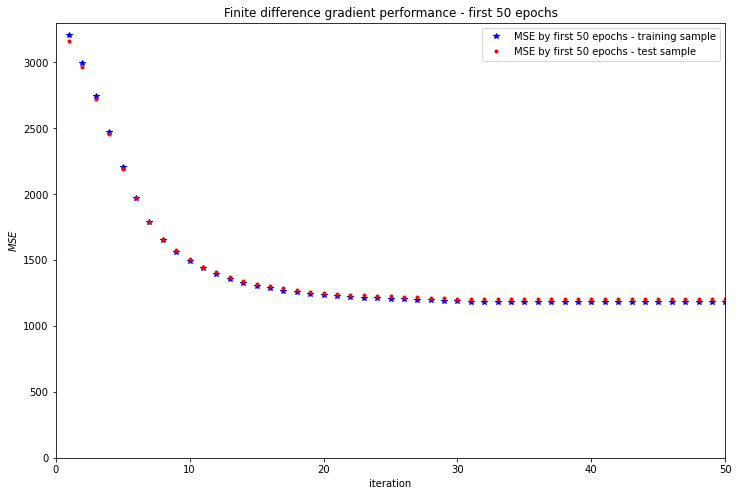

In [58]:
# FDG estimation - first 50 epochs

plt.figure(figsize=(12,8))
plt.plot(epochs[0:50], trainErrors[0:50], '*', c = 'b', label = 'MSE by first 50 epochs - training sample')
plt.plot(epochs[0:50], testErrors[0:50], '.', c = 'r', label = 'MSE by first 50 epochs - test sample')


plt.xlabel('iteration')
plt.ylabel('$MSE$')
plt.xlim((0, 50))
plt.ylim((0,3300))
plt.title('Finite difference gradient performance - first 50 epochs')
plt.legend()

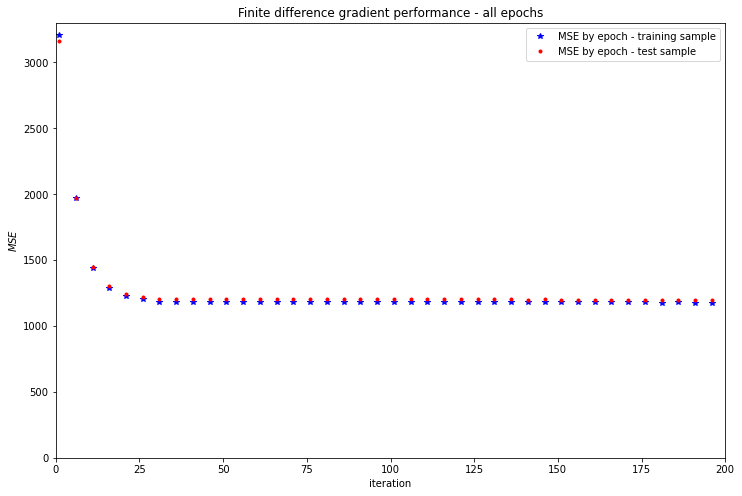

In [61]:
# FDG estimation - all 200 epochs

plt.figure(figsize=(12,8))
plt.plot(epochs[::5], trainErrors[::5], '*', c = 'b', label = 'MSE by epoch - training sample')
plt.plot(epochs[::5], testErrors[::5], '.', c = 'r', label = 'MSE by epoch - test sample')


plt.xlabel('iteration')
plt.ylabel('$MSE$')
plt.xlim((0, 200))
plt.ylim((0,3300))
plt.title('Finite difference gradient performance - all epochs')
plt.legend()

In [42]:
epochs[::10]

[1,
 11,
 21,
 31,
 41,
 51,
 61,
 71,
 81,
 91,
 101,
 111,
 121,
 131,
 141,
 151,
 161,
 171,
 181,
 191]